# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.utils import resample
from scipy.stats import randint, uniform
import joblib

# Load the Data

In [2]:
# Load the dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

# Create Pipeline

In [3]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

# Hyperparameter Grids

In [4]:
# Define the hyperparameter grids for each model
param_grid = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': randint(50, 200),
        'classifier__max_depth': randint(3, 10),
    },
    {
        'classifier': [SVC()],
        'classifier__C': uniform(0.1, 10),
        'classifier__kernel': ['linear', 'rbf'],
    }
]

# Nested Cross-Validation

In [5]:
# Define the cross-validation strategy
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    n_jobs=-1,
    cv=inner_cv,
    verbose=1,
    random_state=42
)

# Perform nested cross-validation
nested_scores = cross_val_score(
    random_search,
    X,
    y,
    cv=outer_cv,
    scoring='accuracy',
    n_jobs=-1
)

# Output the results
print(f'Nested Cross-Validation Accuracy: {nested_scores.mean():.4f} ± {nested_scores.std():.4f}')

Nested Cross-Validation Accuracy: 0.9807 ± 0.0179


# Final Model

In [6]:
# Fit the final model on the entire dataset
final_model = random_search.fit(X, y)

# Output the best model and parameters
print(f'Best Model: {final_model.best_estimator_}')
print(f'Best Hyperparameters: {final_model.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(C=3.408980248526492))])
Best Hyperparameters: {'classifier': SVC(), 'classifier__C': 3.408980248526492, 'classifier__kernel': 'rbf'}


In [7]:
# Perform cross-validation on the full dataset
final_model_cv_scores = cross_val_score(final_model.best_estimator_, X, y, cv=5, scoring='accuracy')
print(f'Final Model Cross-Validation Accuracy: {final_model_cv_scores.mean():.4f} ± {final_model_cv_scores.std():.4f}')

Final Model Cross-Validation Accuracy: 0.9789 ± 0.0070


In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold

# Perform repeated cross-validation
repeated_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
repeated_cv_scores = cross_val_score(final_model.best_estimator_, X, y, cv=repeated_cv, scoring='accuracy')
print(f'Repeated Cross-Validation Accuracy: {repeated_cv_scores.mean():.4f} ± {repeated_cv_scores.std():.4f}')

Repeated Cross-Validation Accuracy: 0.9789 ± 0.0123


In [9]:
from sklearn.model_selection import LeaveOneOut

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Perform LOO-CV
loo_cv_scores = cross_val_score(final_model.best_estimator_, X, y, cv=loo, scoring='accuracy')
print(f'Leave-One-Out Cross-Validation Accuracy: {loo_cv_scores.mean():.4f} ± {loo_cv_scores.std():.4f}')

Leave-One-Out Cross-Validation Accuracy: 0.9842 ± 0.1248


In [10]:
import time
from sklearn.model_selection import LeavePOut

# Start the timer
start_time = time.time()

# Set P
p = 2

# Initialize Leave-P-Out Cross-Validation
lpo = LeavePOut(p=p)

# Perform LPO-CV
lpo_cv_scores = cross_val_score(final_model.best_estimator_, X, y, cv=lpo, scoring='accuracy')
print(f'Leave-P-Out Cross-Validation (P={p}) Accuracy: {lpo_cv_scores.mean():.4f} ± {lpo_cv_scores.std():.4f}')

# End the timer
end_time = time.time()

# Calculate the total time taken
total_time = end_time - start_time

# Convert time to hours, minutes, and seconds
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)

# Print the total time taken in hours, minutes, and seconds
print(f'Total time taken: {int(hours)} hours, {int(minutes)} minutes, and {seconds:.2f} seconds')

Leave-P-Out Cross-Validation (P=2) Accuracy: 0.9837 ± 0.0896
Total time taken: 0 hours, 23 minutes, and 25.34 seconds


In [11]:
# Initialize the list to store bootstrap scores
bootstrap_scores = []

# Number of bootstrap iterations
n_iterations = 1000

# Loop for bootstrap sampling
for i in range(n_iterations):
    # Create a bootstrap sample from the entire dataset
    X_resample, y_resample = resample(X, y, replace=True)

    # Identify the out-of-bag samples (not included in the bootstrap sample)
    oob_mask = np.isin(np.arange(len(X)), np.unique(np.where(np.in1d(X, X_resample))[0]), invert=True)
    X_oob, y_oob = X[oob_mask], y[oob_mask]

    # Train the final model on the bootstrap sample
    model = final_model.best_estimator_
    model.fit(X_resample, y_resample)

    # Evaluate the model on the out-of-bag (OOB) data
    if len(X_oob) > 0:  # Ensure there are OOB samples to evaluate
        y_pred_oob = model.predict(X_oob)
        score = accuracy_score(y_oob, y_pred_oob)
        bootstrap_scores.append(score)

# Calculate the mean and confidence interval of the bootstrap scores
mean_score = np.mean(bootstrap_scores)
confidence_interval = np.percentile(bootstrap_scores, [2.5, 97.5])

# Output the results
print(f'Mean Bootstrap Accuracy: {mean_score:.4f}')
print(f'95% Confidence Interval: {confidence_interval}')

Mean Bootstrap Accuracy: 0.9820
95% Confidence Interval: [0.95774349 1.        ]


# Save the Model

In [12]:
# Save the model to a file
joblib.dump(final_model.best_estimator_, 'final_model.pkl')

# Load the model from the file
loaded_model = joblib.load('final_model.pkl')

# Data Augmentation

In [13]:
!pip install -q imblearn

In [14]:
from imblearn.over_sampling import SMOTE

# Perform synthetic oversampling
smote = SMOTE(random_state=42)
X_augmented, y_augmented = smote.fit_resample(X, y)

augmented_cv_scores = cross_val_score(final_model.best_estimator_, X_augmented, y_augmented, cv=5, scoring='accuracy')
print(f'Augmented Cross-Validation Accuracy: {augmented_cv_scores.mean():.4f} ± {augmented_cv_scores.std():.4f}')

Augmented Cross-Validation Accuracy: 0.9762 ± 0.0123


# Stability Testing

In [15]:
# Perform model stability testing
noise_level = 0.01
perturbed_scores = []

for _ in range(100):
    X_perturbed = X + noise_level * np.random.normal(size=X.shape)
    score = accuracy_score(y, final_model.best_estimator_.predict(X_perturbed))
    perturbed_scores.append(score)

print(f'Mean Perturbed Accuracy: {np.mean(perturbed_scores):.4f} ± {np.std(perturbed_scores):.4f}')

Mean Perturbed Accuracy: 0.8865 ± 0.0121


# Jackknife Resampling

In [18]:
# Initialize the list to store jackknife resampling scores
jackknife_scores = []

for i in range(len(X)):
    # Create the jackknife sample (leave one out)
    if isinstance(X, pd.DataFrame):
        # Handling for pandas DataFrame
        X_jackknife = X.drop(index=X.index[i])
        y_jackknife = y.drop(index=y.index[i])

        # Single row for prediction
        X_i = X.iloc[[i]]
        y_i = y.iloc[i]
    else:
        # Handling for NumPy arrays
        X_jackknife = np.delete(X, i, axis=0)
        y_jackknife = np.delete(y, i, axis=0)

        # Single row for prediction
        X_i = X[i].reshape(1, -1)
        y_i = y[i]

    # Fit the model on the jackknife sample
    jackknife_model = final_model.best_estimator_
    jackknife_model.fit(X_jackknife, y_jackknife)

    # Evaluate the model on the left-out observation
    y_pred = jackknife_model.predict(X_i)
    score = accuracy_score([y_i], y_pred)
    jackknife_scores.append(score)

# Calculate the mean and variance of the jackknife scores
mean_jackknife_score = np.mean(jackknife_scores)
jackknife_variance = np.var(jackknife_scores)

print(f'Jackknife Mean Accuracy: {mean_jackknife_score:.4f}')
print(f'Jackknife Score Variance: {jackknife_variance:.4f}')

Jackknife Mean Accuracy: 0.9842
Jackknife Score Variance: 0.0156


# Model Ensembling

In [19]:
# Access the cross-validation results from the RandomizedSearchCV object
cv_results = pd.DataFrame(random_search.cv_results_)

# Sort the models by their mean cross-validation score in descending order
top_models_df = cv_results.sort_values(by='mean_test_score', ascending=False)

# Extract the top 3 models and their corresponding parameters
top_3_models = top_models_df.iloc[:3]

# Display the top 3 models' mean test scores and parameters
print(top_3_models[['mean_test_score', 'params']])

    mean_test_score                                             params
42         0.984179  {'classifier': SVC(), 'classifier__C': 3.40898...
18         0.982425  {'classifier': SVC(), 'classifier__C': 3.95416...
24         0.982425  {'classifier': SVC(), 'classifier__C': 4.35155...


In [20]:
# Re-create the top 3 models using the extracted parameters
top_model1_params = top_3_models.iloc[0]['params']
top_model2_params = top_3_models.iloc[1]['params']
top_model3_params = top_3_models.iloc[2]['params']

# Re-create the models with the best parameters
top_model1 = final_model.best_estimator_.set_params(**top_model1_params)
top_model2 = final_model.best_estimator_.set_params(**top_model2_params)
top_model3 = final_model.best_estimator_.set_params(**top_model3_params)

In [21]:
from sklearn.ensemble import VotingClassifier

# Create a VotingClassifier ensemble using the top 3 models
ensemble_model = VotingClassifier(
    estimators=[
        ('top_model1', top_model1),
        ('top_model2', top_model2),
        ('top_model3', top_model3)
    ],
    voting='hard'  # 'hard' for majority voting, 'soft' for averaging probabilities
)

In [22]:
# Fit the ensemble model on the entire dataset
ensemble_model.fit(X, y)

# Evaluate the ensemble model using cross-validation
ensemble_cv_scores = cross_val_score(ensemble_model, X, y, cv=5, scoring='accuracy')
print(f'Ensemble Cross-Validation Accuracy: {ensemble_cv_scores.mean():.4f} ± {ensemble_cv_scores.std():.4f}')

Ensemble Cross-Validation Accuracy: 0.9789 ± 0.0070


# Permutation Importance

In [24]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Fit the best model on the entire dataset
fitted_model = final_model.best_estimator_.fit(X, y)

# Compute permutation importance
perm_importance = permutation_importance(fitted_model, X, y, n_repeats=30, random_state=42, n_jobs=-1)

# Extract feature importances and corresponding feature names
feature_importances = perm_importance.importances_mean
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]

# Sort the feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Print the sorted feature importances
print("Feature importances (sorted):")
for i in sorted_idx:
    print(f"{feature_names[i]}: {feature_importances[i]:.4f}")

Feature importances (sorted):
worst texture: 0.0190
worst area: 0.0068
worst smoothness: 0.0062
concavity error: 0.0055
radius error: 0.0053
worst radius: 0.0052
mean concave points: 0.0052
mean concavity: 0.0039
worst symmetry: 0.0035
worst concavity: 0.0035
perimeter error: 0.0035
worst perimeter: 0.0033
area error: 0.0032
compactness error: 0.0032
fractal dimension error: 0.0029
worst fractal dimension: 0.0025
mean texture: 0.0023
texture error: 0.0023
concave points error: 0.0015
worst concave points: 0.0014
mean compactness: 0.0012
mean area: 0.0011
symmetry error: 0.0008
mean symmetry: 0.0006
mean radius: 0.0006
smoothness error: 0.0005
mean perimeter: 0.0001
mean smoothness: -0.0002
mean fractal dimension: -0.0002
worst compactness: -0.0010


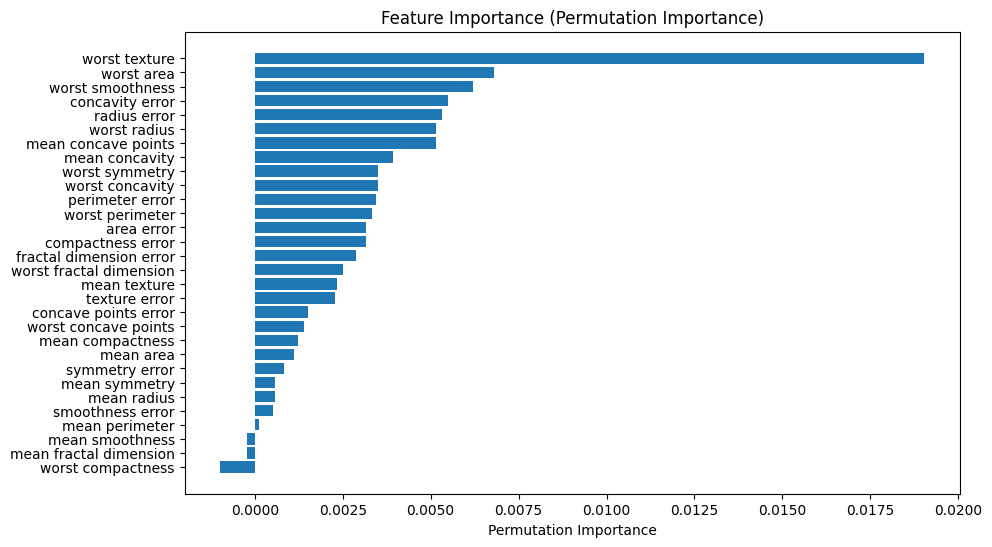

In [25]:
# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation Importance)')
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()